In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mateohervas/dcsass-dataset

 99% 1.33G/1.35G [00:13<00:00, 202MB/s]
100% 1.35G/1.35G [00:14<00:00, 103MB/s]


In [6]:
!unzip dcsass-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_30.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_31.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_4.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_5.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_6.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_7.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_8.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_9.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery145_x264.mp4/Robbery145_x264_0.mp4  
  inflating: dcsass dataset/DCSASS Dataset/Robbery/Robbery145_x264.mp4/Robbery145_x264_1.mp4

In [7]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)


In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tensorflow as tf
import cv2
from sklearn.preprocessing import OneHotEncoder
import csv
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
import datetime  # Added for TensorBoard log directory

In [9]:
# Specify the directory where your CSV files are located
file_path = 'dcsass dataset/DCSASS Dataset/Labels/Shoplifting.csv'
videos_directory = 'dcsass dataset/DCSASS Dataset/Shoplifting'
filename = 'Shoplifting'

def prepareParentVideoPath(video_name):
    video_path = ""
    done = False
    for c in video_name:
        if(done and c == '_'):
            return video_path
        video_path += c
        if(c == '_'):
            done = True
    return ""

# Open the CSV file and read its contents
video_paths = []
labels = []
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Check if the row has at least three elements
        if len(row) >= 3:
            # Iterate over each row in the CSV file
            for row in csv_reader:
                video_path = videos_directory + '/'  + prepareParentVideoPath(row[0]) + '.mp4' + '/' + row[0] + '.mp4' #row[0]
                label = int(row[2]) # Convert the value to an integer
                video_paths.append(video_path)
                labels.append(label)
        else:
            print("Error: Row does not have enough elements")



print(len(video_paths),video_paths)
print(labels)
#print(abnormal_behaviors)

895 ['dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_1.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_2.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_3.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_4.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_5.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_6.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_7.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_8.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_9.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_10.mp4', 'dcsass dataset/DCSASS Dataset/Shoplifting/S

In [10]:
def extract_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for frame_index in np.linspace(0, total_frames - 1, num=num_frames, dtype=int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frame = preprocess_input(frame)
            frames.append(frame)
    cap.release()
    return frames


In [11]:
def frame_generator(video_paths, labels, batch_size=32, num_frames_per_video=10):
    num_videos = len(video_paths)
    while True:
        for start in range(0, num_videos, batch_size):
            end = min(start + batch_size, num_videos)  # Ensure we don't go past the end
            batch_paths = video_paths[start:end]
            batch_labels = labels[start:end]

            batch_data = []
            batch_labels_expanded = []
            for video_path, label in zip(batch_paths, batch_labels):
                frames = extract_frames(video_path, num_frames=num_frames_per_video)
                if not frames:
                    continue  # Skip videos that didn't return any frames
                batch_data.extend(frames)
                batch_labels_expanded.extend([label] * len(frames))

            if not batch_data:  # If no data was added, skip this batch
                print("Skipping empty batch")
                continue

            batch_data = np.array(batch_data)
            batch_labels_expanded = np.array(batch_labels_expanded).reshape(-1, 1)

            #print("Batch data shape:", batch_data.shape)
            #print("Batch labels shape:", batch_labels_expanded.shape)

            yield batch_data, batch_labels_expanded


In [12]:
# split the data into training+validation and test sets
train_val_video_paths, test_video_paths, train_val_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.1, random_state=42
)

# split the remaining data into training and validation sets
train_video_paths, val_video_paths, train_labels, val_labels = train_test_split(
    train_val_video_paths, train_val_labels, test_size=0.22, random_state=42
)

# Convert labels from lists to numpy arrays and reshape
train_labels = np.array(train_labels).reshape(-1, 1)
val_labels = np.array(val_labels).reshape(-1, 1)
test_labels = np.array(test_labels).reshape(-1, 1)

# Print the shapes to verify
print("Shapes of the label arrays:")
print("Train labels:", train_labels.shape)
print("Validation labels:", val_labels.shape)
print("Test labels:", test_labels.shape)

# Print sizes of each dataset to check splits
print("Training set size:", len(train_video_paths))
print("Validation set size:", len(val_video_paths))
print("Test set size:", len(test_video_paths))

Shapes of the label arrays:
Train labels: (627, 1)
Validation labels: (178, 1)
Test labels: (90, 1)
Training set size: 627
Validation set size: 178
Test set size: 90


In [13]:
batch_size = 1
train_generator = frame_generator(train_video_paths, train_labels, batch_size=batch_size)
val_generator = frame_generator(val_video_paths, val_labels, batch_size=batch_size)
test_generator = frame_generator(test_video_paths, test_labels, batch_size=batch_size)

In [16]:
# Train the model
epochs = 12
steps_per_epoch = len(train_video_paths) // batch_size
validation_steps = len(val_video_paths) // batch_size
test_steps= len(test_video_paths) // batch_size

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Modify your model architecture to include dropout and regularization
model = Sequential([
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Add dropout
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Add L2 regularization
])

# Compile the model with the same optimizer and loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Fit the model with the new callbacks and class_weight
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    shuffle=True,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]  # Add new callbacks here
)


Epoch 1/12
627/627 [==============================] - 160s 236ms/step - loss: 1.4541 - accuracy: 0.6305 - val_loss: 0.9798 - val_accuracy: 0.4287 - lr: 1.0000e-04
Epoch 2/12
627/627 [==============================] - 133s 213ms/step - loss: 1.1182 - accuracy: 0.6786 - val_loss: 0.7954 - val_accuracy: 0.5051 - lr: 1.0000e-04
Epoch 3/12
627/627 [==============================] - 145s 231ms/step - loss: 0.7978 - accuracy: 0.7807 - val_loss: 0.8460 - val_accuracy: 0.4433 - lr: 1.0000e-04
Epoch 4/12
627/627 [==============================] - 145s 231ms/step - loss: 0.5094 - accuracy: 0.8868 - val_loss: 0.6389 - val_accuracy: 0.7034 - lr: 1.0000e-04
Epoch 5/12
627/627 [==============================] - 134s 215ms/step - loss: 0.4257 - accuracy: 0.8995 - val_loss: 0.8944 - val_accuracy: 0.4612 - lr: 1.0000e-04
Epoch 6/12
627/627 [==============================] - 131s 210ms/step - loss: 0.3626 - accuracy: 0.9124 - val_loss: 0.4345 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 7/12
627/627 [==

In [35]:
model.save('model_finalized.keras')

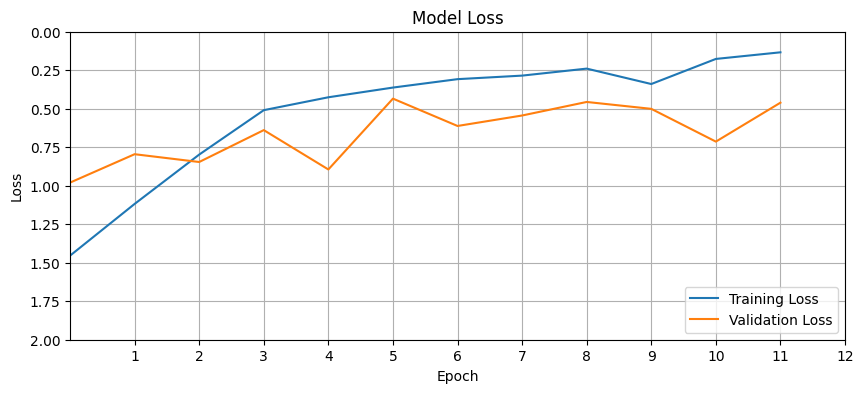

In [40]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
plt.figure(figsize=(10, 4))
x = np.arange(1, 13)  # Array from 1 to 10
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(2,0)
plt.xlim(0,12)
plt.legend(loc='lower right')
plt.xticks(x)  # This will set the ticks to be exactly at the values in 'x'
plt.grid()
plt.savefig("final_model_loss.png")
plt.show()

In [41]:
from tensorflow.keras.models import load_model

# Load the model
#model = load_model('result_with_class_weights.keras')


# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_steps
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


90/90 [==============================] - 15s 165ms/step - loss: 0.4972 - accuracy: 0.8211
Test Loss: 0.49716490507125854
Test Accuracy: 0.8211110830307007


1/1 [==============================] - 0s 25ms/step
Classification Report:
              precision    recall  f1-score   support

   Not Theft       0.81      1.00      0.90       730
       Theft       0.00      0.00      0.00       170

    accuracy                           0.81       900
   macro avg       0.41      0.50      0.45       900
weighted avg       0.66      0.81      0.73       900



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


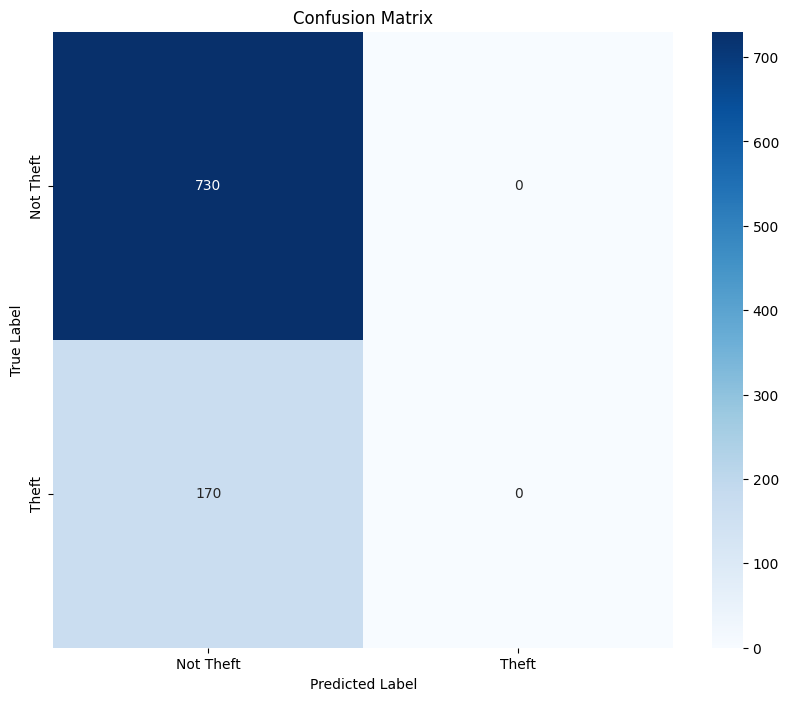

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_and_plot(model: Model, data_generator, total_samples: int):
    # Predictions and labels storage
    predictions = []
    labels = []

    # Iterate through the generator
    for _ in range(total_samples):
        batch_data, batch_labels = next(data_generator)  # Get batch
        batch_predictions = model.predict(batch_data)
        predictions.extend(np.argmax(batch_predictions, axis=1))  # Store predicted classes
        labels.extend(batch_labels)  # Store true labels

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(labels, predictions)
    report = classification_report(labels, predictions, target_names=['Not Theft', 'Theft'])  # Adjust class names as needed

    # Print classification report
    print("Classification Report:")
    print(report)

    # Plotting the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Theft', 'Theft'], yticklabels=['Not Theft', 'Theft'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision = precision_score(labels, predictions)

    # Recall = TP / (TP + FN)
    recall = recall_score(labels, predictions)

    # F1 Score = 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(labels, predictions)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# Example usage:
# Assuming model, test_generator, and test_steps are predefined
evaluate_and_plot(model, test_generator, test_steps)